In [1]:
# Code outline:
# 1. Indoor system - data:
#   a. Read data and parameters
#   b. process data (measurements)
# 2. Outdoor system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light HOBO data
# 3. Offshore system - data:
#   a. Read data and parameters
#   b. Process data (measurements)
#   c. Build interpolations functions for temperature and light IMS data
# 4. Calculate model results for:
#   a. Indoor system
#   b. Outdoor system
#   c. Offshore system
# 5. Calculate errors in the combined df
# df_combined structure:
#System, time, m_exp, m_mod, m_SRE,Nint_exp, Nint_mod, Nint_SRE Next_exp, Next_mod, Next_SRE
# 6... minimize errors?

In [6]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions import *

import datetime

pandas version is 1.1.3


In [3]:
# 1. Indoor system
#   a. Read data and parameters from excel file

xl = pd.ExcelFile('../data/Parameters.xlsx')
x2 = pd.ExcelFile('../data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

# Import indoor data into df2
df2 = x2.parse('Indoor')

df2.head()

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 2.002
miu 0.027
Nintmax 4.2
Nintmin 0.7
Ks 14.0
Vmax 60.0
Z 0.178
KI 20.0
K0 1.5
Ka 0.15
Topt 18.0
Tmin 5.0
Tmax 31.5
n 2.0
losses20 0.0016
teta 1.047
Sopt 18.0
Smin 0.0
Smax 45.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.0
dNextindt 0.0
dmoutdt 0.0


,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,NH4,NO3,DGR,Treatment,Weighing,Trimming,Sporulated,Comment,Day,Comment2
0,0.0,1,0,0.0,i,"2019,3,12,13,0","2019,3,12,13,0","2019,3,12,13,0",0.750,NaN,...,NaN,NaN,NaN,Acclimation,NaN,NaN,No,NaN,NaN,NaN
1,0.7,1,0,0.0,f,"2019,3,12,13,0","2019,3,12,13,0","2019,3,19,13,0",0.753,50.0,...,NaN,NaN,NaN,Acclimation,NaN,NaN,No,NaN,NaN,NaN
2,1.0,1,1,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.144,NaN,...,NaN,NaN,NaN,1000/1/168,NaN,NaN,No,NaN,NaN,NaN
3,2.0,1,2,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.153,NaN,...,NaN,NaN,NaN,1000/1/168,NaN,NaN,No,NaN,NaN,NaN
4,3.0,1,3,1.0,i,"2019,3,19,13,0","2019,3,19,13,0","2019,3,19,13,0",0.159,NaN,...,NaN,NaN,NaN,1000/1/168,NaN,NaN,No,NaN,NaN,NaN


In [4]:
# b. process data (indoor measurements)

    # 1. Convert Time into hours
T = []
for i in df2['Sample'][:]:
    T1 = df2['Timei'][df2['Sample'].values.tolist().index(i)]
    T2 = df2['Time'][df2['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
df2['T'] = T

    # 2. Make a temp DF (df2_temp) by filtering the original df - remove 'wierd' results (i.e sporulation) 

df2_Reduced = df2[(df2.Treatment != 'Acclimation') & (df2.Week <= 3) & (df2.Stage != 'i') & (df2.Sporulated == 'No')]
df2_Reduced

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,NO3,DGR,Treatment,Weighing,Trimming,Sporulated,Comment,Day,Comment2,T
11,1.7,1,1,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.408,4.8,...,NaN,0.261905,1000/1/168,0.0,0.0,No,NaN,NaN,NaN,165
12,2.7,1,2,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.426,5.1,...,NaN,0.254902,1000/1/168,0.0,0.0,No,NaN,NaN,NaN,165
13,3.7,1,3,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.330,5.3,...,NaN,0.153639,1000/1/168,0.0,0.0,No,NaN,NaN,NaN,165
14,4.7,1,4,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,5.2,...,NaN,0.101648,2000/1/4,0.0,0.0,No,NaN,NaN,NaN,165
15,5.7,1,5,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,4.8,...,NaN,0.122024,2000/1/4,0.0,0.0,No,NaN,NaN,NaN,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,145.7,5,5,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.321,NaN,...,NaN,0.162857,500/3/168,0.0,0.0,No,NaN,NaN,NaN,501
469,146.7,5,6,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.297,NaN,...,NaN,0.140000,500/3/168,0.0,0.0,No,NaN,NaN,NaN,501
470,147.7,5,7,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.357,NaN,...,NaN,0.197143,200/5/168,0.0,0.0,No,NaN,NaN,NaN,501
471,148.7,5,8,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.336,NaN,...,NaN,0.177143,200/5/168,0.0,0.0,No,NaN,NaN,NaN,501


In [5]:
# 2. Outdoor system - data:
#   a. Read data and parameters

# Import outdoor data into df3
df3 = x2.parse('Outdoor')

# no need to read parameters now - may need later on if need to change parameters between systems 

In [ ]:
# b. process data (outdoor measurements)
    # 1. Convert Time into hours
T = []
for i in df3['Sample'][:]:
    T1 = df3['Timeh'][df3['Sample'].values.tolist().index(i)]
    T2 = df3['Time'][df3['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
    
df3.loc[:,'T'] = T
    # 2. Make a temp df (df3_temp) by filtering the original df - remove irrelevant results (i.e not ulva, etc) 
df3f = df3[(df3.Stage == 'f')]
df3i = df3[(df3.Stage == 'i')]
# DWi = df3i.DW
# Ni = df3i.N
df3f = df3f.assign(DWi = df3i.DW.values)
df3f = df3f.assign(Ni = df3i.N.values)


df3Reduced = df3f[(df3f.Species == 'Ulva') & 
                  (df3f.Water == 'Seawater') & 
                  (df3f['Comment 2'] != 'Shaded') & 
                  (np.isnan(df3f.Ni) != True) & 
                  (df3f['Sample'] >= 62)]
#'Shaded' was removed in order to avoid the need to add a shade function - this can be added later on 

df3Reduced.head()

In [7]:
# c. Organize temperature and light HOBO data (interpolations functions will come later)
    # 1. Import HOBO excel
x3 = pd.ExcelFile('../data/HOBO.xlsx')
df3HOBO = x3.parse('Outdoor')

    # 2. light and temperature function - import data
import re

xHOBO = pd.ExcelFile('../data/HOBO.xlsx')
dfHOBO = xHOBO.parse('Outdoor',header=None)

dfHOBO

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Total Air 2019 27.02.-2020 28.10.. Mikhmoret....,NaN,NaN,NaN,NaN,NaN,NaN,Total Water 2019 14.02.-2020 28.10.. Mikhmoret...,NaN,NaN,NaN,NaN,NaN
2,NaN,Date Time. GMT +0200,Temp. °C,Intensity. lux,NaN,NaN,NaN,#,Date Time,Temp. °C,Intensity. lux,Intensity [umol photons/m2/second],PAR
3,#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2019-02-27 15:46:45,17.07,2 317,NaN,NaN,NaN,1,2019-02-14 17:13:19,15.14,158,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1328,2020-10-28 07:24:24,26.55,1 228,NaN,NaN
59679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1329,2020-10-28 07:39:24,26.64,1 283,NaN,NaN
59680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1330,2020-10-28 07:54:24,26.81,1 557,NaN,NaN
59681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1331,2020-10-28 08:09:24,26.98,1 628,NaN,NaN


In [8]:
# 2. light data - fill up missing data and convert all data to float - save in Iwater

IHOBO = dfHOBO.iloc[4:59683:1][10]
j = 0
Iwater = []
for i in IHOBO:
    if type(i) == float:
        i = IHOBO[j-97]

    if type(i) == int:
        i = str(i)

    if type(i) == str:
        i = re.sub(r"\s+", "", i, flags=re.UNICODE)
    IHOBO[j] = float(i)
    j = j + 1
    Iwater.append(float(i))

/home/user/miniconda3/envs/meiron/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/user/miniconda3/envs/meiron/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-8-a2985f79dd59>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [9]:
# 2. Temperature data - fill up missing data and convert all data to float - save in Twater

THOBO = dfHOBO.iloc[4:59683:1][10]
j = 0
Twater = []
for i in THOBO:
    if type(i) == float:
        i = THOBO[j-97]

    if type(i) == int:
        i = str(i)

    if type(i) == str:
        i = re.sub(r"\s+", "", i, flags=re.UNICODE)
    THOBO[j] = float(i)
    j = j + 1
    Twater.append(float(i))

<ipython-input-9-ed68f1498d3c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  THOBO[j] = float(i)


In [10]:
# 2. light and temperature data - save average hourly values in TV_average and IV_average

IV, IV_average, TV, TV_average = [],[],[],[]
for vali,valT in zip(Iwater,dfHOBO.iloc[3:59683:1][9]):
    IV.append(vali*0.019*0.43)
    TV.append(float(valT))
for i in range(1,len(IV),4):
    IV_average.append(np.mean(IV[i-1:i+3:1]))
    TV_average.append(np.mean(TV[i-1:i+3:1]))

In [11]:
# 3. Offshore system - data:
#   a. Read data and parameters
# Import offshore data into df4
df4 = x2.parse('Offshore')

In [12]:
# b. process data (offshore measurements)
    # 1. Convert Time into hours
T = []
for i in df4['Sample'][:]:
    T1 = df4['Timeh'][df4['Sample'].values.tolist().index(i)]
    T2 = df4['Time'][df4['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
df4['T'] = T
    # 2. Make a temp df (df4_temp) by filtering the original df - remove irrelevant results (i.e 1m depth, unsuccessful experiment etc)
df4Reduced = df4[(df4.Stage == 'f')][(df4.Depth == 5)][(df4.Exp != 1)][(df4.Period == 1)]
df4Reduced


<ipython-input-12-e1b1f2e858fb>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4Reduced = df4[(df4.Stage == 'f')][(df4.Depth == 5)][(df4.Exp != 1)][(df4.Period == 1)]
<ipython-input-12-e1b1f2e858fb>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4Reduced = df4[(df4.Stage == 'f')][(df4.Depth == 5)][(df4.Exp != 1)][(df4.Period == 1)]
<ipython-input-12-e1b1f2e858fb>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df4Reduced = df4[(df4.Stage == 'f')][(df4.Depth == 5)][(df4.Exp != 1)][(df4.Period == 1)]


,Sample,Exp,Period,Cage,Depth,Stage,Days,Timei,Timeh,Time,...,S,Protein,Starch,NH4,NO3,DGR,Treatment,Comment,Comment 2,T
62,53.70,2,1,13,5,f,7.0,"2019,7,22,11,0","2019,7,22,11,0","2019,7,29,13,0",...,NaN,NaN,NaN,0.396883,NaN,0.077470,1000 / 7 / 18,fertilization in a 35 liter container,NaN,170
63,54.70,2,1,14,5,f,7.0,"2019,7,22,11,0","2019,7,22,11,0","2019,7,29,13,0",...,NaN,NaN,NaN,0.396883,NaN,0.177315,1000 / 7 / 18,fertilization in a 35 liter container,NaN,170
64,55.70,2,1,15,5,f,7.0,"2019,7,22,11,0","2019,7,22,11,0","2019,7,29,13,0",...,NaN,NaN,NaN,0.396883,NaN,0.192143,1000 / 7 / 18,fertilization in a 35 liter container,NaN,170
65,56.70,2,1,16,5,f,7.0,"2019,7,22,11,0","2019,7,22,11,0","2019,7,29,13,0",...,NaN,NaN,NaN,0.396883,NaN,0.124470,NaN,NaN,NaN,170
66,57.70,2,1,17,5,f,7.0,"2019,7,22,11,0","2019,7,22,11,0","2019,7,29,13,0",...,NaN,NaN,NaN,0.396883,NaN,0.129353,NaN,NaN,NaN,170
67,58.70,2,1,18,5,f,7.0,"2019,7,22,11,0","2019,7,22,11,0","2019,7,29,13,0",...,NaN,NaN,NaN,0.396883,NaN,0.106246,NaN,NaN,NaN,170
119,93.70,3,1,13,5,f,7.0,"2019,10,30,13,0","2019,10,30,13,0","2019,11,06,11,0",...,NaN,NaN,NaN,1.451602,NaN,0.069286,NaN,NaN,NaN,166
120,94.70,3,1,14,5,f,7.0,"2019,10,30,13,0","2019,10,30,13,0","2019,11,06,11,0",...,NaN,NaN,NaN,1.451602,NaN,0.082143,NaN,NaN,NaN,166
121,95.70,3,1,15,5,f,7.0,"2019,10,30,13,0","2019,10,30,13,0","2019,11,06,11,0",...,NaN,NaN,NaN,1.451602,NaN,0.082143,NaN,NaN,NaN,166
122,96.70,3,1,16,5,f,7.0,"2019,10,30,13,0","2019,10,30,13,0","2019,11,06,11,0",...,NaN,NaN,NaN,1.451602,NaN,0.067143,NaN,NaN,NaN,166


In [13]:
# c. Build interpolations functions for temperature and light IMS data
    # 1. Import combined IMS excel
dfims = pd.read_csv('../data/ims.csv',encoding= 'unicode_escape',header=None)
    # 2. temperature function
    
    # Complete
    
    # 3. light function
days = list(range(1,290))
I_plot = np.zeros(24*290)
light_hours = list(range(5,19))
for day in days:
    for hour in light_hours:
        I_plot[(day - 1)*24 + hour] = float(dfims.iloc[day][hour-1])


all_hours = list(range(1,(291-1)*24+1))
f0 = interpolate.interp1d(all_hours, I_plot,kind = 'linear')

In [14]:
# 4. Calculate model results for:
#   a. Indoor system
    # I. Produce an array ("m/Nint/Next_mod_all") of all model results (hours 1-504) for each treatment

In [15]:
df2_Reduced

,Sample,Exp,Sleeve,Week,Stage,Timei,Timeh,Time,DW,mmi,...,NO3,DGR,Treatment,Weighing,Trimming,Sporulated,Comment,Day,Comment2,T
11,1.7,1,1,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.408,4.8,...,NaN,0.261905,1000/1/168,0.0,0.0,No,NaN,NaN,NaN,165
12,2.7,1,2,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.426,5.1,...,NaN,0.254902,1000/1/168,0.0,0.0,No,NaN,NaN,NaN,165
13,3.7,1,3,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.330,5.3,...,NaN,0.153639,1000/1/168,0.0,0.0,No,NaN,NaN,NaN,165
14,4.7,1,4,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,5.2,...,NaN,0.101648,2000/1/4,0.0,0.0,No,NaN,NaN,NaN,165
15,5.7,1,5,1.0,f,"2019,3,19,13,0","2019,3,19,13,0","2019,3,26,10,0",0.267,4.8,...,NaN,0.122024,2000/1/4,0.0,0.0,No,NaN,NaN,NaN,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,145.7,5,5,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.321,NaN,...,NaN,0.162857,500/3/168,0.0,0.0,No,NaN,NaN,NaN,501
469,146.7,5,6,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.297,NaN,...,NaN,0.140000,500/3/168,0.0,0.0,No,NaN,NaN,NaN,501
470,147.7,5,7,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.357,NaN,...,NaN,0.197143,200/5/168,0.0,0.0,No,NaN,NaN,NaN,501
471,148.7,5,8,3.0,f,"2019,11,28,12,0","2019,12,12,12,0","2019,12,19,9,0",0.336,NaN,...,NaN,0.177143,200/5/168,0.0,0.0,No,NaN,NaN,NaN,501



Treatment: 1000/1/168
Number of samples:
m: 48 Nint: 34 Next: 37
7.0
0.0
Starting point
168.0
Duration
336.0
Duration

Treatment: 500/2/168
Number of samples:
m: 95 Nint: 41 Next: 123
3.5
0.0
Starting point
84.0
Period
168.0
Duration
252.0
Period
336.0
Duration
420.0
Period

Treatment: 500/3/168
Number of samples:
m: 35 Nint: 23 Next: 33
2.3333333333333335
0.0
Starting point
56.0
Period
112.0
Period
168.0
Duration
224.0
Period
280.0
Period
336.0
Duration
392.0
Period
448.0
Period

Treatment: 2000/1/168
Number of samples:
m: 9 Nint: 9 Next: 9
7.0
0.0
Starting point
168.0
Duration
336.0
Duration

Treatment: 200/5/168
Number of samples:
m: 9 Nint: 6 Next: 6
1.4
0.0
Starting point
34.0
Period
68.0
Period
102.0
Period
136.0
Period
170.0
Duration
204.0
Period
238.0
Period
272.0
Period
306.0
Period
340.0
Duration
374.0
Period
408.0
Period
442.0
Period
476.0
Period


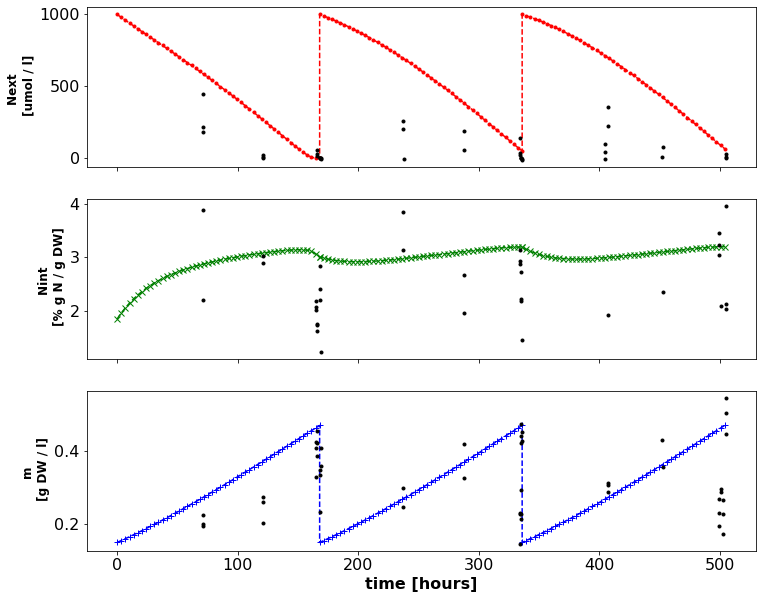

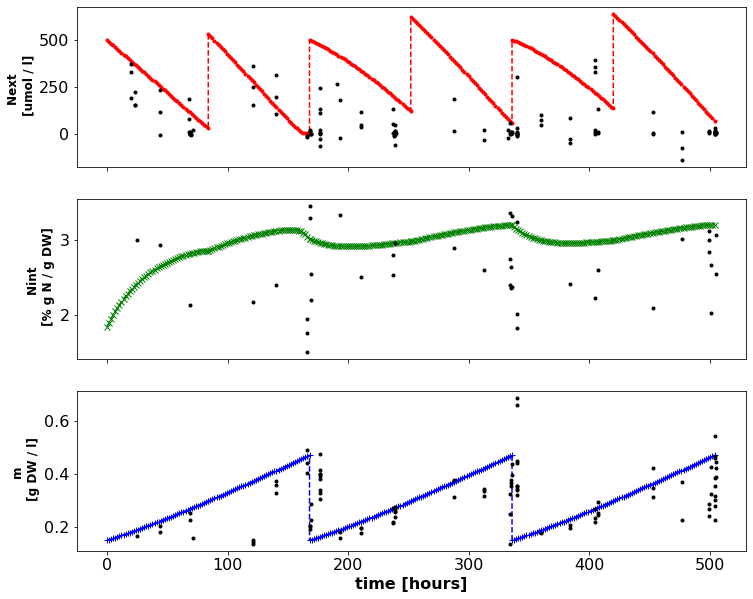

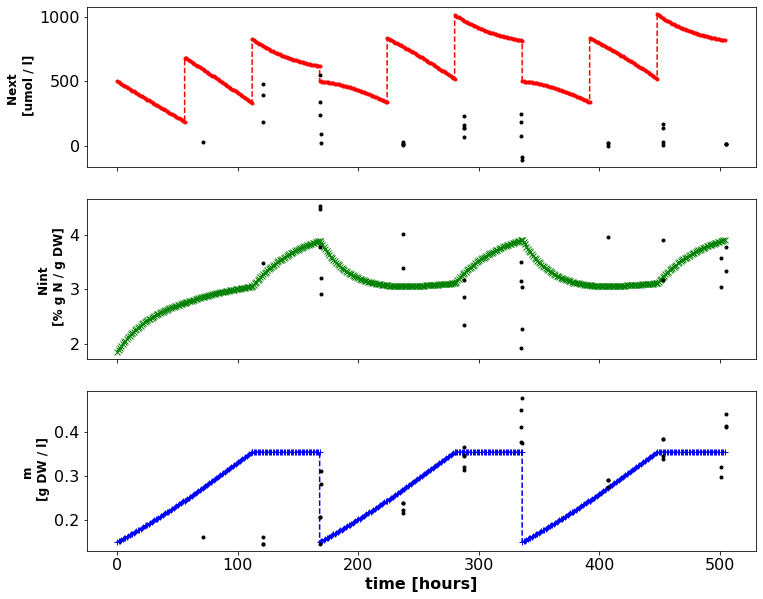

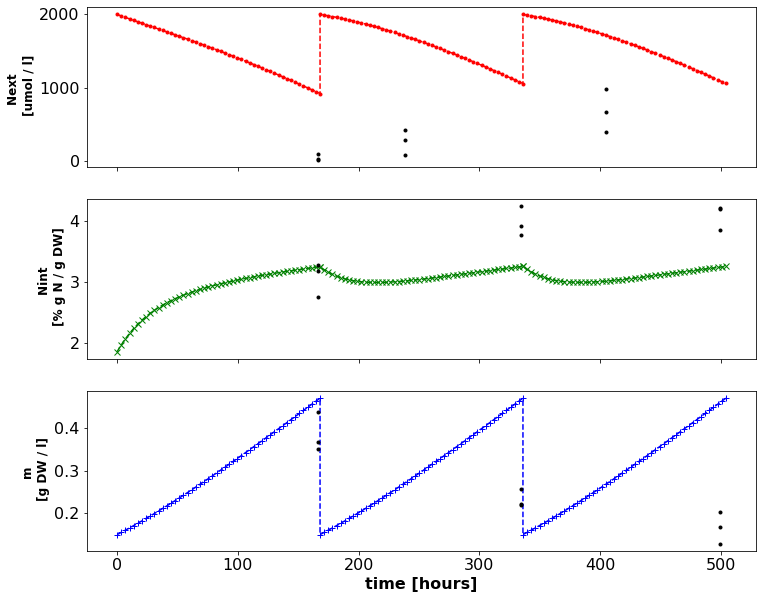

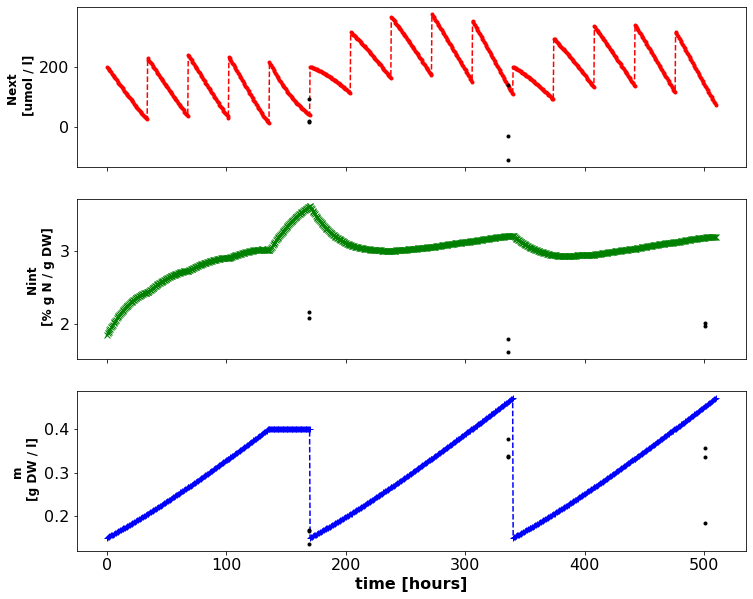

In [16]:
# model simulations and measured data for the different treatments - fix problem with time (x axis) in 1000/1/168

TModAll = []
mExpAllTimes,NintExpAllTimes,NextExpAllTimes = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]

Treatments = ['1000/1/168','500/2/168','500/3/168','2000/1/168','200/5/168']

Temp = 22
#I0 = 80
S = 20 # fix salinity function and S=40

for i in Treatments:
    print('\nTreatment: ' + str(i))
    df2Temp = df2_Reduced[(df2_Reduced.Treatment == i)]
    mTemp = df2Temp[(np.isnan(df2Temp.DW) != True)]['DW']
    mTimeTemp = df2Temp[(np.isnan(df2Temp.DW) != True)]['T']
    NintTemp = df2Temp[(np.isnan(df2Temp.N) != True)]['N']
    NintTimeTemp = df2Temp[(np.isnan(df2Temp.N) != True)]['T']
    NextTemp = df2Temp[(np.isnan(df2Temp.NH4) != True)]['NH4']
    NextTimeTemp = df2Temp[(np.isnan(df2Temp.NH4) != True)]['T']
    mTemp = df2Temp[(~np.isnan(df2Temp.DW))]['DW']
    mTimeTemp = df2Temp[(~np.isnan(df2Temp.DW))]['T']
    NintTemp = df2Temp[(~np.isnan(df2Temp.N))]['N']
    NintTimeTemp = df2Temp[(~np.isnan(df2Temp.N))]['T']
    NextTemp = df2Temp[(~np.isnan(df2Temp.NH4))]['NH4']
    NextTimeTemp = df2Temp[(~np.isnan(df2Temp.NH4))]['T']
    print('Number of samples:\nm: ' + str(len(mTimeTemp)) + ' Nint: ' + str(len(NintTimeTemp)) + ' Next: ' + str(len(NextTimeTemp)))
    
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1])
    print(Period)
    Duration = Tr[2]/24
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Duration*3
    count_periods = 0
    
    #T1 = '2019,02,14,17,0'
    #T2 = df3Temp['Timei']
    #T2 = T2.tolist()[0]
    #t0 = Time_to_Hours(T1,T2)
    
    for hour in np.arange(0,n_days*24,round(Period*24,0)):
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0
            m_0 = m0
            Next_0 = Amplitude
        
        if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
            count_periods = count_periods + 1
            
            if count_periods == Tr[1]:
                print('Duration')
                # reset everything, except Nint
                Nint_0 = NINT[-1][-1]
                Next_0 = Amplitude
                m_0 = m0
                count_periods = 0
            else:
                # period passed, not Duration
                # add amplitude, keep going 
                print('Period')
                Next_0 = NEXT[-1][-1] + Amplitude
                Nint_0 = NINT[-1][-1]
                m_0 = M[-1][-1]


        # setup initial conditions
        for i in range(7,17):
            if (np.mod(hour,24)-i) == 0:
                I0 = 0
            else: 
                I0 = 80
        x0 = [Next_0,Nint_0,m_0]
        t = np.linspace(hour,hour+Period*24)

        x = odeint(controlled_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,S,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,Temp,I0))

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)
        
        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)
    
    TModAll.append(TT)
    mExpAllTimes.append(mTimeTemp)
    NintExpAllTimes.append(NintTimeTemp)
    NextExpAllTimes.append(NextTimeTemp)
    
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)

    plot_result(t_model,Next_model,Nint_model,m_model,Nint=NintTemp,tNint=NintTimeTemp,m=mTemp,tm=mTimeTemp,Next=NextTemp,tNext=NextTimeTemp)

In [17]:
for i in range(0,23):
    if (np.mod(hour,24)-i) == 0:
        print(np.mod(hour,24))
        print(str(i) + ' night')

20.0
20 night


In [18]:
TModTemp = []
TModAllOrg = []
mModReducedAll, NintModReducedAll, NextModReducedAll = [],[],[]
for i in range(len(TModAll)):
    print(i)
    for j in range(len(TModAll[i])):
        Ttemp = TModAll[i][j]
        for k in Ttemp:
            if k > 504:
                k = 504
            TModTemp.append(k)
    TModAllOrg.append(TModTemp)
    TModTemp = []

for i in range(len(TModAll)):
    gm = interpolate.interp1d(TModAllOrg[i], mModAll[i],kind = 'linear')
    mModReduced = []
    for j in mExpAllTimes[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        mModReduced.append(gm(j))
    mModReducedAll.append(mModReduced)
    gNint = interpolate.interp1d(TModAllOrg[i], NintModAll[i],kind = 'linear')
    NintModReduced = []
    for j in NintExpAllTimes[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NintModReduced.append(gNint(j))
    NintModReducedAll.append(NintModReduced)
    gNext = interpolate.interp1d(TModAllOrg[i], NextModAll[i],kind = 'linear')    
    NextModReduced = []
    for j in NextExpAllTimes[i]:
        if j >= 168 and j < 180:
            j = 167.9
        if j >= 336 and j < 345:
            j = 335.9
        if j > 504:
            j = 504
        NextModReduced.append(gNext(j))
    NextModReducedAll.append(NextModReduced)

0
1
2
3
4


In [19]:
df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)][(df2_Reduced.Treatment == i)]

<ipython-input-19-c85577494fcc>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)][(df2_Reduced.Treatment == i)]


In [20]:
mSRE_All,NintSRE_All,NextSRE_All = [],[],[]
for i in range(len(Treatments)):
    mSRE,NintSRE,NextSRE = [],[],[]
    
    df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)][(df2_Reduced.Treatment == Treatments[i])]
    print('Treatment: ' + str(Treatments[i]) + '\n\nm\n')
    print('Number of samples: ' + str(len(df2m.Sample)) + '\n')
    k = 0
    for j in df2m.Sample:
        mexp = df2m.DW
        mmod = mModReducedAll[i]
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3)
    mSRE_All.append(mSRE)
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)][(df2_Reduced.Treatment == Treatments[i])]
    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample:
        Nintexp = df2Nint.N
        Nintmod = NintModReducedAll[i]
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3)
    NintSRE_All.append(NintSRE)
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)][(df2_Reduced.Treatment == Treatments[i])]
    print('\nNext\n')
    print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    k = 0
    for j in df2Next.Sample:
        Nextexp = df2Next.NH4
        if Nextexp.iloc[k] < 0:
            Nextexp.iloc[k] = 0
        Nextmod = NextModReducedAll[i]
        NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
        print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENext = round((np.mean(NextSRE))**0.5,3)
    NextSRE_All.append(NextSRE)
    print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
    print('End of treatment ' + str(Treatments[i]) + '\n')

Treatment: 1000/1/168

m

Number of samples: 48

Sample #1
Measured biomass: 0.408
Modeled biomass: 0.465

Sample #2
Measured biomass: 0.426
Modeled biomass: 0.465

Sample #3
Measured biomass: 0.33
Modeled biomass: 0.465

Sample #11
Measured biomass: 0.294
Modeled biomass: 0.469

Sample #12
Measured biomass: 0.213
Modeled biomass: 0.469

Sample #13
Measured biomass: 0.228
Modeled biomass: 0.469

Sample #21
Measured biomass: 0.267
Modeled biomass: 0.469

Sample #22
Measured biomass: 0.174
Modeled biomass: 0.469

Sample #23
Measured biomass: 0.228
Modeled biomass: 0.469

Sample #31
Measured biomass: 0.423
Modeled biomass: 0.467

Sample #32
Measured biomass: 0.387
Modeled biomass: 0.467

Sample #33
Measured biomass: 0.456
Modeled biomass: 0.467

Sample #41
Measured biomass: 0.231
Modeled biomass: 0.467

Sample #42
Measured biomass: 0.228
Modeled biomass: 0.467

Sample #43
Measured biomass: 0.147
Modeled biomass: 0.467

Sample #51
Measured biomass: 0.27
Modeled biomass: 0.461

Sample #52
M

<ipython-input-20-316ea6e970af>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2m = df2_Reduced[(np.isnan(df2_Reduced.DW) != True)][(df2_Reduced.Treatment == Treatments[i])]
<ipython-input-20-316ea6e970af>:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)][(df2_Reduced.Treatment == Treatments[i])]
<ipython-input-20-316ea6e970af>:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)][(df2_Reduced.Treatment == Treatments[i])]
/home/user/miniconda3/envs/meiron/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, va

In [21]:
mSRE_AllTemp = []
for i in range(len(mSRE_All)):
    for j in range(len(mSRE_All[i])):
        mSRE_AllTemp.append(mSRE_All[i][j])
RMSREm = round((np.mean(mSRE_AllTemp))**0.5,3)
print(RMSREm)

0.306


In [22]:
NintSRE_AllTemp = []
for i in range(len(NintSRE_All)):
    for j in range(len(NintSRE_All[i])):
        NintSRE_AllTemp.append(NintSRE_All[i][j])
RMSRENint = round((np.mean(NintSRE_AllTemp))**0.5,3)
print(RMSRENint)

0.258


In [23]:
NextSRE_AllTemp = []
for i in range(len(NextSRE_All)):
    for j in range(len(NextSRE_All[i])):
        NextSRE_AllTemp.append(NextSRE_All[i][j])
RMSRENext = round((np.mean(NextSRE_AllTemp))**0.5,3)
print(RMSRENext)

60.932


In [24]:
# II. Make a filtered array including only times of empiric measurement (remove from array results from times in which data was not measured)
# III. Add relevant columns from df2_temp and the model results to a new df_combined

In [25]:
#   b. Outdoor system
    # I. Produce an array ("m/Nint_mod") of all model results for final m value (depends on m0, time, light, T and more) - done by runing the model in a loop
    
    
    # *requires model function with constant Next 
    #II. Add relevant columns from df3_temp and the model results to a new df_combined

In [26]:
df3Reduced

,Sample,Exp,Sleeve,Stage,Days,Timei,Timeh,Time,DW,mm,...,Water,Species,Generation,Age,Age 2,Comment,Comment 2,T,DWi,Ni
135,63.13,11,2,f,13.0,"2019,02,14,17,0","2019,02,14,17,0","2019,02,27,12,0",1.105270,7.368466,...,Seawater,Ulva,1,NaN,NaN,NaN,NaN,307,0.233347,2.942855
137,65.13,11,4,f,13.0,"2019,02,14,17,0","2019,02,14,17,0","2019,02,27,12,0",1.249991,8.333277,...,Seawater,Ulva,1,NaN,NaN,NaN,NaN,307,0.466693,3.080304
138,66.13,11,5,f,13.0,"2019,02,14,17,0","2019,02,14,17,0","2019,02,27,12,0",1.383512,9.223416,...,Seawater,Ulva,1,NaN,NaN,NaN,NaN,307,0.583367,2.672773
164,82.14,12,10,f,14.0,"2019,02,28,12,0","2019,02,28,12,0","2019,03,13,12,0",1.518620,10.124134,...,Seawater,Ulva,1,NaN,NaN,NaN,NaN,312,0.350020,3.492575
207,101.13,14,6,f,13.0,"2019,03,28,12,0","2019,03,28,12,0","2019,04,10,12,0",0.112006,0.746709,...,Seawater,Ulva,1,NaN,NaN,NaN,NaN,312,0.466693,3.649515
212,106.13,14,11,f,13.0,"2019,03,28,12,0","2019,03,28,12,0","2019,04,10,12,0",1.636927,10.912846,...,Seawater,Ulva,1,NaN,NaN,NaN,NaN,312,0.700040,3.649515
251,120.15,16,1,f,15.0,"2019,04,29,12,0","2019,04,29,12,0","2019,05,14,12,0",0.000000,NaN,...,Seawater,Ulva,1,NaN,NaN,NaN,NaN,360,0.466693,3.994200
322,157.14,19,1,f,14.0,"2019,06,12,12,0","2019,06,12,12,0","2019,06,26,12,0",0.875890,5.839267,...,Seawater,Ulva,1,NaN,NaN,NaN,NaN,336,0.350020,2.740069
343,168.14,20,2,f,14.0,"2019,06,26,12,0","2019,06,26,12,0","2019,07,10,12,0",0.611952,4.079678,...,Seawater,Ulva,1,NaN,NaN,NaN,NaN,336,0.116673,3.151096
344,169.14,20,3,f,14.0,"2019,06,26,12,0","2019,06,26,12,0","2019,07,10,12,0",0.705407,4.702713,...,Seawater,Ulva,1,NaN,NaN,NaN,NaN,336,0.233347,2.204029


In [27]:
IV_average[1:307]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.6238275,
 60.006607499999994,
 93.85695999999999,
 115.4155475,
 72.586365,
 54.1813975,
 168.86573,
 48.0661525,
 63.7076175,
 17.610435000000003,
 7.2222800000000005,
 0.36356499999999997,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9293374999999999,
 4.665069999999999,
 19.4629825,
 26.9998075,
 32.2857975,
 29.332342500000003,
 76.8572325,
 25.878475,
 305.4865125,
 71.73668500000001,
 4.12585,
 0.4902,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0020425,
 13.3885875,
 104.4881725,
 74.76367,
 219.40943499999997,
 364.3003,
 481.5500125,
 369.1512375,
 483.10027,
 437.87932,
 204.69526499999998,
 19.963395,
 1.548215,
 0.0,
 0.012254999999999999,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0020425,
 3.7439025,
 50.1004825,
 122.366175,
 104.0858,
 282.3123075,
 393.3099275,
 386.347045,
 462.14422,
 436.16566249999994,
 218.8600025,
 18.505

In [28]:
TV_average[1:307]

[16.740000000000002,
 16.6225,
 16.502499999999998,
 16.4075,
 16.215,
 15.987499999999999,
 15.57,
 15.3325,
 15.045,
 15.28,
 15.227500000000001,
 15.0025,
 14.8825,
 15.207500000000001,
 15.7125,
 16.1825,
 16.48,
 16.2975,
 17.1125,
 16.7375,
 16.652500000000003,
 16.2575,
 16.02,
 15.9025,
 15.86,
 15.8375,
 15.8175,
 15.73,
 15.505,
 15.537500000000001,
 15.504999999999999,
 15.55,
 15.4,
 15.314999999999998,
 15.217500000000001,
 15.407500000000002,
 15.325,
 14.787500000000001,
 14.65,
 14.767500000000002,
 15.0,
 15.7625,
 16.31,
 15.837499999999999,
 17.675,
 16.845,
 15.635,
 15.332500000000001,
 15.120000000000001,
 14.862499999999999,
 14.3675,
 13.83,
 13.447500000000002,
 13.145,
 12.9525,
 12.7375,
 12.4925,
 12.3125,
 12.065,
 11.775,
 11.535,
 13.105,
 15.0525,
 17.767500000000002,
 19.1325,
 20.105,
 20.127499999999998,
 20.9625,
 21.509999999999998,
 20.192500000000003,
 17.2625,
 16.665,
 16.490000000000002,
 16.355,
 16.1675,
 16.0625,
 15.9025,
 15.73999999999999

In [29]:
#miu = 0.045
mSRE2, NintSRE2 = [], []
Samples = df3Reduced.Sample.tolist()
Next_0 = 35
for i in Samples:
    df3Temp = df3Reduced[df3Reduced.Sample == i] 
    m_0 = df3Temp.DWi
    Nint_0 = df3Temp.Ni
    t = df3Temp['T']
    t = t.tolist()[0]
    T1 = '2019,02,14,17,0'
    T2 = df3Temp['Timei']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)
    
    # light function
    IV_reduced = IV_average[t0:t0+t]
    fI0 = interpolate.interp1d(range(t), IV_reduced,kind = 'linear')

    # T function
    TV_reduced = TV_average[t0:t0+t]
    fTemp0 = interpolate.interp1d(range(t), TV_reduced,kind = 'linear')
    
    print('\nSample: #' + str(math.floor(i)))
    mexp = df3Temp.DW
    mexp = mexp.tolist()[0]
    Nintexp = df3Temp.N
    Nintexp = Nintexp.tolist()[0]
    
    NEXT, NINT, M, TT = [],[],[],[]

    #n_days = Duration*3
    #count_periods = 0
    
    x0 = [Next_0,Nint_0,m_0]  
    for hour in range(t):
        # setup initial conditions
             
        I0 = fI0(hour)
        #print('I0 = ' + str(I0))
        
        Temp = fTemp0(hour)
        #print('Temp = ' + str(Temp))
        x = odeint(constant_N_new,x0,range(t),args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,Temp,I0))

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(range(t))

        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)

    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    mmod = m_model[-1]
    mSRE2.append(((mexp-mmod)/mmod)**2)
    print('Initial biomass: ' + str(round(m_0,3)))
    print('Measured biomass: ' + str(round(mexp,3)))
    print('Modeled biomass: ' + str(round(float(mmod),3)) + '\n')

    Nintmod = Nint_model[-1]
    NintSRE2.append(((Nintexp-Nintmod)/Nintmod)**2)
    print('Initial Nint: ' + str(round(Nint_0,3)))
    print('Measured Nint: ' + str(round(Nintexp,3)))
    print('Modeled Nint: ' + str(round(float(Nintmod),3)) + '\n')
    print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')

    #plot_result(t_model,Next_model,Nint_model,m_model,Nint=[Nint_0,Nintexp],tNint=[0,t],m=[m_0,mexp],tm=[0,t],Next=[Next_0],tNext=[0])

RMSREm2 = round((np.mean(mSRE))**0.5,3)
RMSRENint2 = round((np.mean(NintSRE))**0.5,3)
print('The RMSRE of m in the outdoor system is: ' + str(RMSREm2) + '\n')
print('The RMSRE of Nint in the outdoor system is: ' + str(RMSRENint2) + '\n')


Sample: #63
Initial biomass: 135    0.233
Name: DWi, dtype: float64
Measured biomass: 1.105
Modeled biomass: 0.473

Initial Nint: 135    2.943
Name: Ni, dtype: float64
Measured Nint: nan
Modeled Nint: 3.563

Modeled Next: 35.0


Sample: #65
Initial biomass: 137    0.467
Name: DWi, dtype: float64
Measured biomass: 1.25
Modeled biomass: 0.64

Initial Nint: 137    3.08
Name: Ni, dtype: float64
Measured Nint: 2.854
Modeled Nint: 3.712

Modeled Next: 35.0


Sample: #66
Initial biomass: 138    0.583
Name: DWi, dtype: float64
Measured biomass: 1.384
Modeled biomass: 0.72

Initial Nint: 138    2.673
Name: Ni, dtype: float64
Measured Nint: 3.446
Modeled Nint: 3.76

Modeled Next: 35.0


Sample: #82
Initial biomass: 164    0.35
Name: DWi, dtype: float64
Measured biomass: 1.519
Modeled biomass: 0.688

Initial Nint: 164    3.493
Name: Ni, dtype: float64
Measured Nint: nan
Modeled Nint: 3.556

Modeled Next: 35.0


Sample: #101
Initial biomass: 207    0.467
Name: DWi, dtype: float64
Measured biomass

KeyboardInterrupt: 

In [ ]:
Next_model

In [ ]:
mSRE2_All,Nint2SRE_All= [],[]
for i in range(len(Samples)):
    mSRE2,NintSRE2 = [],[]
    
    df3m = df3_Reduced[(df3_Reduced.Sample == Samples[i])]
    print('Sample: ' + str(Sample[i]) + '\n\nm\n')
    #k = 0
    #for j in df2m.Sample:
    mexp = df2m.DW
    mmod = mModReducedAll[i]
        mSRE.append(((mexp.iloc[k]-mmod[k])/mmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured biomass: ' + str(round(mexp.iloc[k],3)))
        print('Modeled biomass: ' + str(round(float(mmod[k]),3)) + '\n')
        k = k + 1
    RMSREm = round((np.mean(mSRE))**0.5,3)
    mSRE_All.append(mSRE)
    print('The RMSRE of m in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSREm) + '\n')
    print('end of treatment ' + str(Treatments[i]) + '\n')
    
    df2Nint = df2_Reduced[(np.isnan(df2_Reduced.N) != True)][(df2_Reduced.Treatment == Treatments[i])]
    print('\nNint\n')
    print('Number of samples: ' + str(len(df2Nint.Sample)) + '\n')
    k = 0
    for j in df2Nint.Sample:
        Nintexp = df2Nint.N
        Nintmod = NintModReducedAll[i]
        NintSRE.append(((Nintexp.iloc[k]-Nintmod[k])/Nintmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Nint: ' + str(round(float(Nintexp.iloc[k]),3)))     
        print('Modeled Nint: ' + str(round(float(Nintmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENint = round((np.mean(NintSRE))**0.5,3)
    NintSRE_All.append(NintSRE)
    print('\nThe RMSRE of Nint in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENint) + '\n')
    
    df2Next = df2_Reduced[(np.isnan(df2_Reduced.NH4) != True)][(df2_Reduced.Treatment == Treatments[i])]
    print('\nNext\n')
    print('Number of samples: ' + str(len(df2Next.Sample)) + '\n')
    k = 0
    for j in df2Next.Sample:
        Nextexp = df2Next.NH4
        if Nextexp.iloc[k] < 0:
            Nextexp.iloc[k] = 0
        Nextmod = NextModReducedAll[i]
        NextSRE.append(((Nextexp.iloc[k]-Nextmod[k])/Nextmod[k])**2)
        print('Sample #' + str(math.floor(float(j))))
        print('Measured Next: ' + str(round(float(Nextexp.iloc[k]),3)))     
        print('Modeled Next: ' + str(round(float(Nextmod[k]),3)) + '\n')        
        k = k + 1
    RMSRENext = round((np.mean(NextSRE))**0.5,3)
    NextSRE_All.append(NextSRE)
    print('\nThe RMSRE of Next in treamtment ' + str(Treatments[i]) + ' is: ' + str(RMSRENext) + '\n')
    print('End of treatment ' + str(Treatments[i]) + '\n')

In [ ]:
# model simulations and measured data for outdoor system

TModAll = []
mExpAllTimes,NintExpAllTimes,NextExpAllTimes = [],[],[]
mModAll,NintModAll,NextModAll = [],[],[]


Temp = 22
I0 = 80
S = 20 # fix salinity function and S=40

for i in Treatments:
    print('\nTreatment: ' + str(i))
    df2Temp = df2_Reduced[(df2_Reduced.Treatment == i)]
    mTemp = df2Temp[(np.isnan(df2Temp.DW) != True)]['DW']
    mTimeTemp = df2Temp[(np.isnan(df2Temp.DW) != True)]['T']
    NintTemp = df2Temp[(np.isnan(df2Temp.N) != True)]['N']
    NintTimeTemp = df2Temp[(np.isnan(df2Temp.N) != True)]['T']
    NextTemp = df2Temp[(np.isnan(df2Temp.NH4) != True)]['NH4']
    NextTimeTemp = df2Temp[(np.isnan(df2Temp.NH4) != True)]['T']
    mTemp = df2Temp[(~np.isnan(df2Temp.DW))]['DW']
    mTimeTemp = df2Temp[(~np.isnan(df2Temp.DW))]['T']
    NintTemp = df2Temp[(~np.isnan(df2Temp.N))]['N']
    NintTimeTemp = df2Temp[(~np.isnan(df2Temp.N))]['T']
    NextTemp = df2Temp[(~np.isnan(df2Temp.NH4))]['NH4']
    NextTimeTemp = df2Temp[(~np.isnan(df2Temp.NH4))]['T']
    print('Number of samples:\nm: ' + str(len(mTimeTemp)) + ' Nint: ' + str(len(NintTimeTemp)) + ' Next: ' + str(len(NextTimeTemp)))
    
    Tr = []
    Tr = i.split('/')
    Tr = [float(i) for i in Tr]
    Amplitude = Tr[0]
    Period = float(7/Tr[1])
    print(Period)
    Duration = Tr[2]/24
    
    NEXT, NINT, M, TT = [],[],[],[]

    n_days = Duration*3
    count_periods = 0
    
    for hour in np.arange(0,n_days*24,round(Period*24,0)):
        print(hour)
        if hour == 0:
            print('Starting point')
            Nint_0 = Nint0
            m_0 = m0
            Next_0 = Amplitude

        if hour > 0 and np.mod(hour,round(Period*24,0)) == 0:
            count_periods = count_periods + 1
            
            if count_periods == Tr[1]:
                print('Duration')
                # reset everything, except Nint
                Nint_0 = NINT[-1][-1]
                Next_0 = Amplitude
                m_0 = m0
                count_periods = 0

            else:
                # period passed, not Duration
                # add amplitude, keep going 
                print('Period')
                Next_0 = NEXT[-1][-1] + Amplitude
                Nint_0 = NINT[-1][-1]
                m_0 = M[-1][-1]


        # setup initial conditions
        x0 = [Next_0,Nint_0,m_0]
        t = np.linspace(hour,hour+Period*24)

        x = odeint(controlled_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,S,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,Temp,I0))

        NEXT.append(x[: , 0])
        NINT.append(x[: , 1])
        M.append(x[: , 2])
        TT.append(t)

        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)
    
    TModAll.append(TT)
    mExpAllTimes.append(mTimeTemp)
    NintExpAllTimes.append(NintTimeTemp)
    NextExpAllTimes.append(NextTimeTemp)
    
    mModAll.append(m_model)
    NintModAll.append(Nint_model)
    NextModAll.append(Next_model)

    plot_result(t_model,Next_model,Nint_model,m_model,Nint=NintTemp,tNint=NintTimeTemp,m=mTemp,tm=mTimeTemp,Next=NextTemp,tNext=NextTimeTemp)

In [ ]:
#   c. Offshore system
    # I. Produce an array ("m/Nint_mod") of all model results for final m value (depends time, light, T and more) - done by runing the model in a loop
    # *requires model function wit constant Next
    # II. Add relevant columns from df3_temp and the model results to a new df_combined

In [ ]:
# 5. Calculate SRE for m, Nint and Next in DF_combined